In [59]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [60]:
real_state = pd.read_csv("train.csv")

In [61]:
real_state.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [65]:
real_state.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

In [33]:
real_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [34]:
real_state_numeric = real_state.select_dtypes(include=["float64", "int64"])
real_state_numeric

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


In [35]:
real_state_numeric = real_state_numeric.drop(['Id', 'MSSubClass','OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                              'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 
                                              'GarageCars', 'MoSold', 'YrSold', 'FullBath', 'HalfBath', 'Fireplaces', 
                                              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'], axis=1)

In [68]:
?pd.DataFrame.fillna

In [36]:
real_state_numeric

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450,196.0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0,208500
1,80.0,9600,0.0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0,181500
2,68.0,11250,162.0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0,223500
3,60.0,9550,0.0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0,140000
4,84.0,14260,350.0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,0.0,953,953,953,694,0,1647,460,0,40,0,0,0,0,0,175000
1456,85.0,13175,119.0,589,1542,2073,0,0,2073,500,349,0,0,0,0,0,0,210000
1457,66.0,9042,0.0,877,1152,1188,1152,0,2340,252,0,60,0,0,0,0,2500,266500
1458,68.0,9717,0.0,0,1078,1078,0,0,1078,240,366,0,112,0,0,0,0,142125


In [37]:
real_state_numeric.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

In [38]:
cor = real_state_numeric.corr()

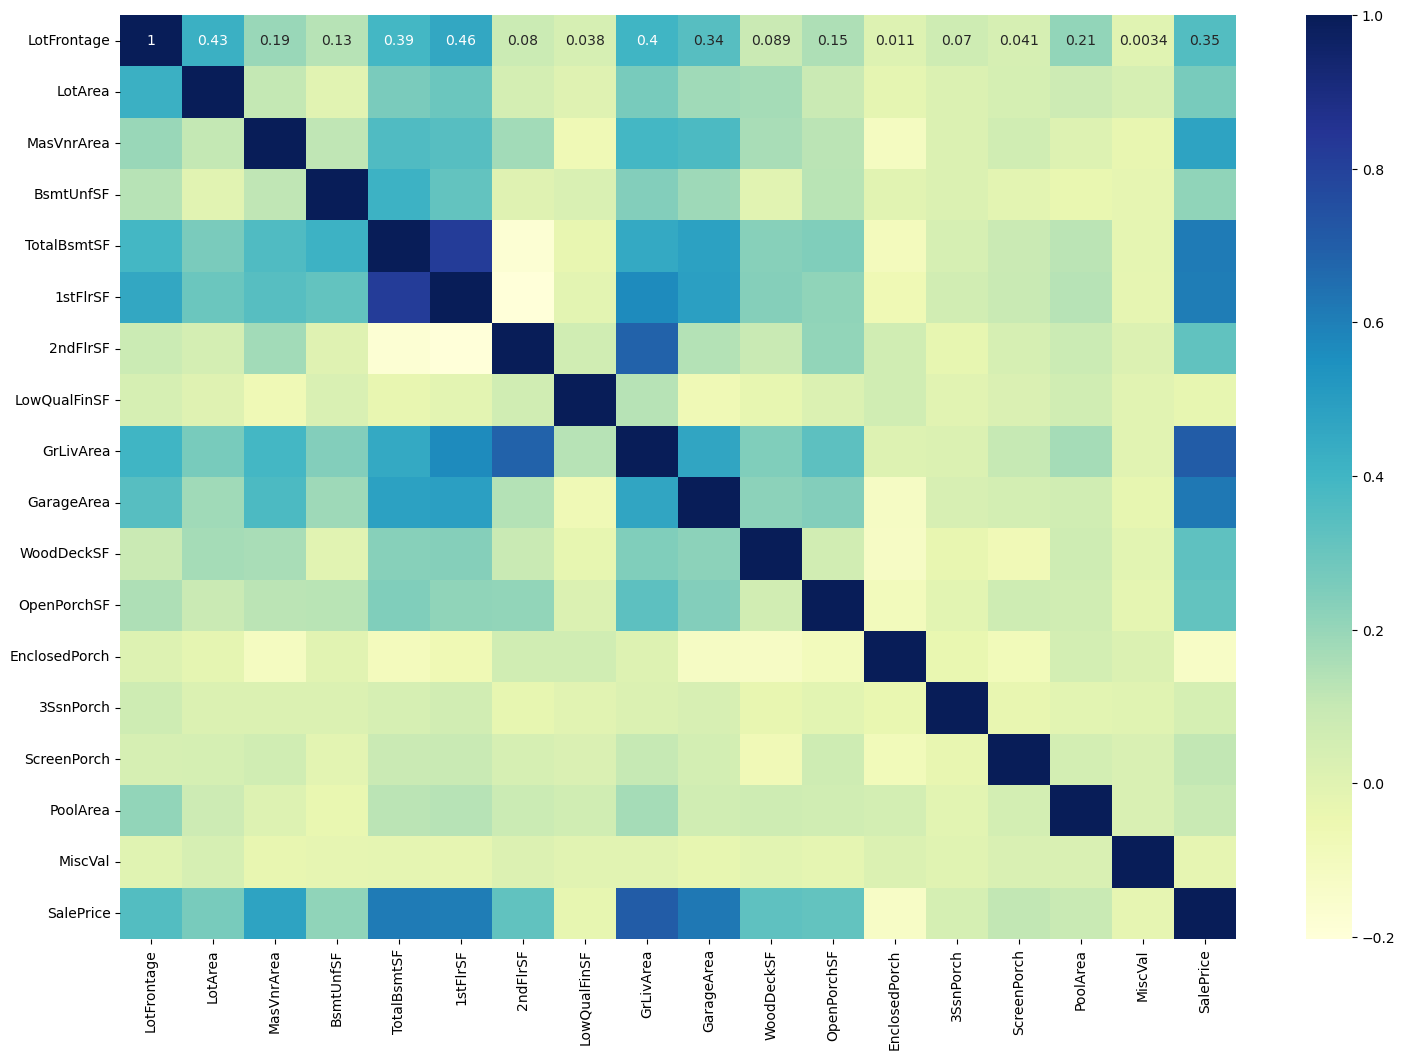

In [39]:
plt.figure(figsize=(18, 12))

sns.heatmap(cor,cmap="YlGnBu" , annot=True)
plt.show()

In [40]:
real_state_categorical_1 = real_state.loc[:, ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                              'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                                              'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces', 
                                              'GarageYrBlt','GarageCars', 'MoSold', 'YrSold']]
real_state_categorical_1 = real_state_categorical_1.astype("object")
real_state_categorical_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSSubClass    1460 non-null   object
 1   OverallQual   1460 non-null   object
 2   OverallCond   1460 non-null   object
 3   YearBuilt     1460 non-null   object
 4   YearRemodAdd  1460 non-null   object
 5   BsmtFinSF1    1460 non-null   object
 6   BsmtFinSF2    1460 non-null   object
 7   BsmtFullBath  1460 non-null   object
 8   BsmtHalfBath  1460 non-null   object
 9   FullBath      1460 non-null   object
 10  HalfBath      1460 non-null   object
 11  BedroomAbvGr  1460 non-null   object
 12  KitchenAbvGr  1460 non-null   object
 13  TotRmsAbvGrd  1460 non-null   object
 14  Fireplaces    1460 non-null   object
 15  GarageYrBlt   1379 non-null   object
 16  GarageCars    1460 non-null   object
 17  MoSold        1460 non-null   object
 18  YrSold        1460 non-null   object
dtypes: obj

In [41]:
real_state_categorical_1.head()

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold
0,60,7,5,2003,2003,706,0,1,0,2,1,3,1,8,0,2003.0,2,2,2008
1,20,6,8,1976,1976,978,0,0,1,2,0,3,1,6,1,1976.0,2,5,2007
2,60,7,5,2001,2002,486,0,1,0,2,1,3,1,6,1,2001.0,2,9,2008
3,70,7,5,1915,1970,216,0,1,0,1,0,3,1,7,1,1998.0,3,2,2006
4,60,8,5,2000,2000,655,0,1,0,2,1,4,1,9,1,2000.0,3,12,2008


In [42]:
real_state_categorical_1.isnull().sum()

MSSubClass       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt     81
GarageCars       0
MoSold           0
YrSold           0
dtype: int64

In [43]:
real_state_categorical_1["GarageYrBlt"] = real_state_categorical_1["GarageYrBlt"].astype("Int64")
real_state_categorical_1 = real_state_categorical_1.astype("object")
real_state_categorical_1

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold
0,60,7,5,2003,2003,706,0,1,0,2,1,3,1,8,0,2003,2,2,2008
1,20,6,8,1976,1976,978,0,0,1,2,0,3,1,6,1,1976,2,5,2007
2,60,7,5,2001,2002,486,0,1,0,2,1,3,1,6,1,2001,2,9,2008
3,70,7,5,1915,1970,216,0,1,0,1,0,3,1,7,1,1998,3,2,2006
4,60,8,5,2000,2000,655,0,1,0,2,1,4,1,9,1,2000,3,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,5,1999,2000,0,0,0,0,2,1,3,1,7,1,1999,2,8,2007
1456,20,6,6,1978,1988,790,163,1,0,2,0,3,1,7,2,1978,2,2,2010
1457,70,7,9,1941,2006,275,0,0,0,2,0,4,1,9,2,1941,1,5,2010
1458,20,5,6,1950,1996,49,1029,1,0,1,0,2,1,5,0,1950,1,4,2010


In [44]:
real_state_categorical_2 = real_state.select_dtypes(include=["object"])
real_state_categorical_2

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [45]:
real_state_categorical_2.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [46]:
real_state_categorical_2.isnull().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [47]:
real_state_categorical_1_dummies = pd.get_dummies(real_state_categorical_1, drop_first=True, dtype=int)
real_state_categorical_1_dummies

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1457,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
real_state_categorical_2_dummies = pd.get_dummies(real_state_categorical_2, drop_first=True, dtype=int)
real_state_categorical_2_dummies

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1456,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1457,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1458,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [49]:
real_state_cat_final = pd.concat([real_state_categorical_1_dummies, real_state_categorical_2_dummies], axis=1)
real_state_cat_final

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1457,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [50]:
real_state_numeric.isnull().sum()

LotFrontage      259
LotArea            0
MasVnrArea         8
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
SalePrice          0
dtype: int64

In [52]:
real_state_numeric.fillna(0, inplace=True)
real_state_numeric

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450,196.0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0,208500
1,80.0,9600,0.0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0,181500
2,68.0,11250,162.0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0,223500
3,60.0,9550,0.0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0,140000
4,84.0,14260,350.0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,0.0,953,953,953,694,0,1647,460,0,40,0,0,0,0,0,175000
1456,85.0,13175,119.0,589,1542,2073,0,0,2073,500,349,0,0,0,0,0,0,210000
1457,66.0,9042,0.0,877,1152,1188,1152,0,2340,252,0,60,0,0,0,0,2500,266500
1458,68.0,9717,0.0,0,1078,1078,0,0,1078,240,366,0,112,0,0,0,0,142125


In [53]:
real_state_final = pd.concat([real_state_numeric, real_state_cat_final], axis=1)
real_state_final

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,150,856,856,854,0,1710,548,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,0.0,284,1262,1262,0,0,1262,460,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,162.0,434,920,920,866,0,1786,608,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,0.0,540,756,961,756,0,1717,642,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,350.0,490,1145,1145,1053,0,2198,836,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,0.0,953,953,953,694,0,1647,460,...,0,0,0,0,1,0,0,0,1,0
1456,85.0,13175,119.0,589,1542,2073,0,0,2073,500,...,0,0,0,0,1,0,0,0,1,0
1457,66.0,9042,0.0,877,1152,1188,1152,0,2340,252,...,0,0,0,0,1,0,0,0,1,0
1458,68.0,9717,0.0,0,1078,1078,0,0,1078,240,...,0,0,0,0,1,0,0,0,1,0


In [58]:
real_state_final["SalePrice"].value_counts()

SalePrice
140000    20
135000    17
155000    14
145000    14
190000    13
          ..
202665     1
164900     1
208300     1
181500     1
147500     1
Name: count, Length: 663, dtype: int64

In [55]:
y = real_state_final.pop(real_state_final["SalePrice"])
X = real_state_final["SalePrice"]

KeyError: "None of [Index([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900,\n       118000,\n       ...\n       136000, 287090, 145000,  84500, 185000, 175000, 210000, 266500, 142125,\n       147500],\n      dtype='int64', length=1460)] are in the [columns]"

In [ ]:
scaler = MinMaxScaler()
cols = X.columns
X = pd.DataFrame(scaler.fit_transform(X))
y = pd.DataFrame(scaler.transform(y))
X.columns = cols
X.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
X_test = pd.DataFrame(scaler.transform(X_test))

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

In [ ]:
print(lm.intercept_)
print(lm.coef_)